0.1%

/home/mamusiaarusia/praktyki/walidacja_funkcji.py:122: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],


100.0%

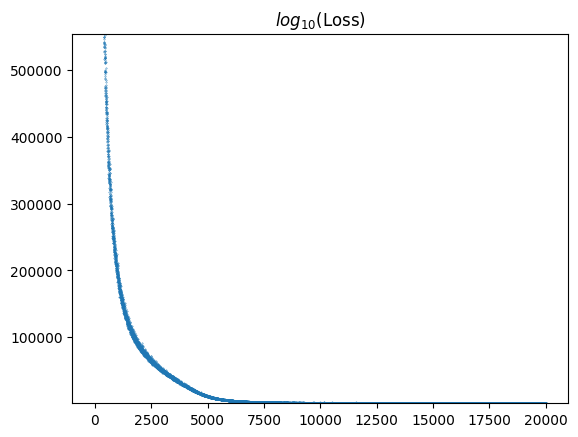

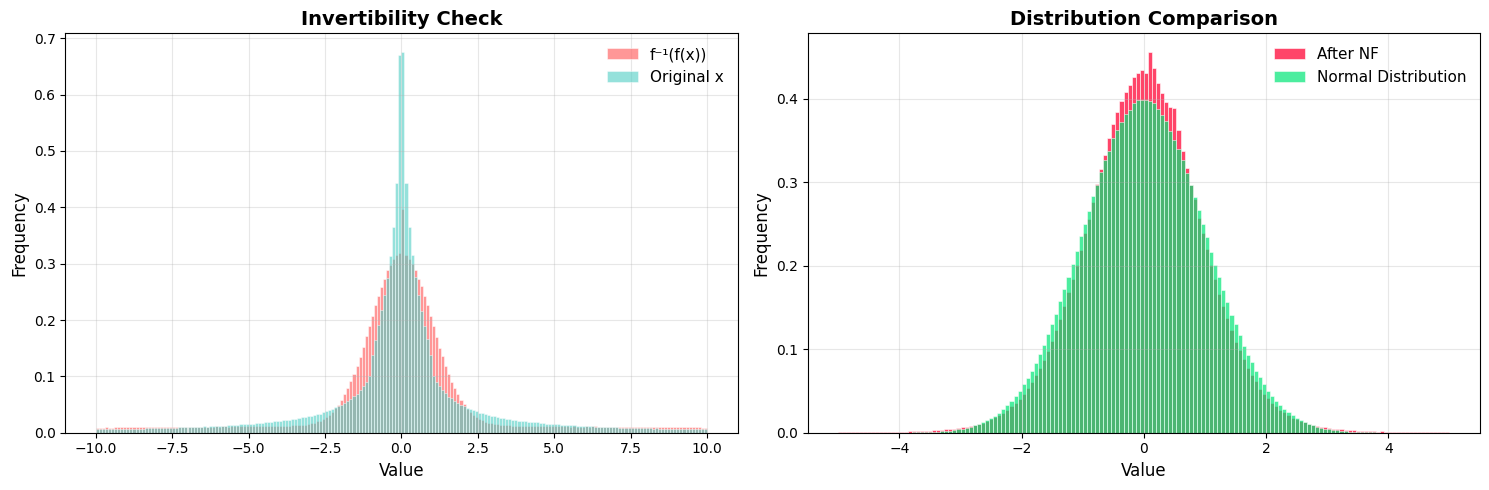

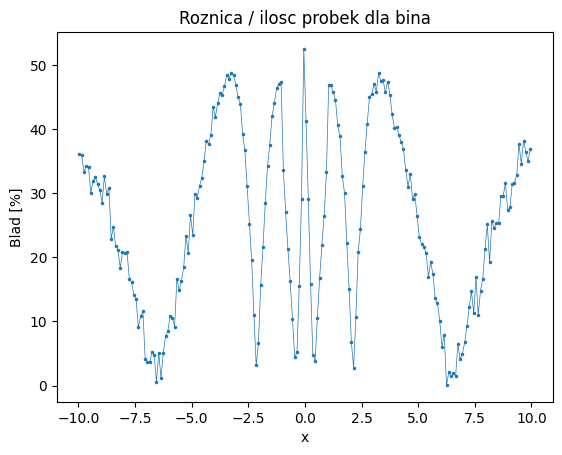

100.0%

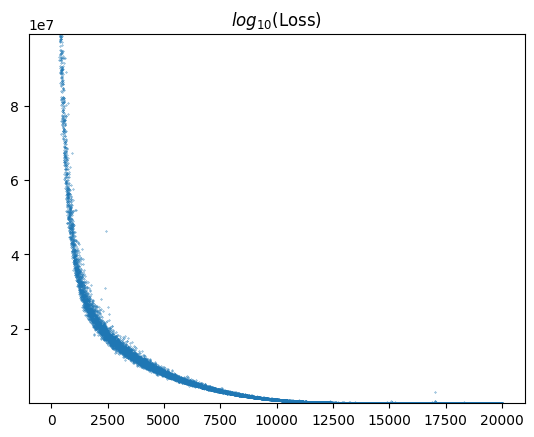

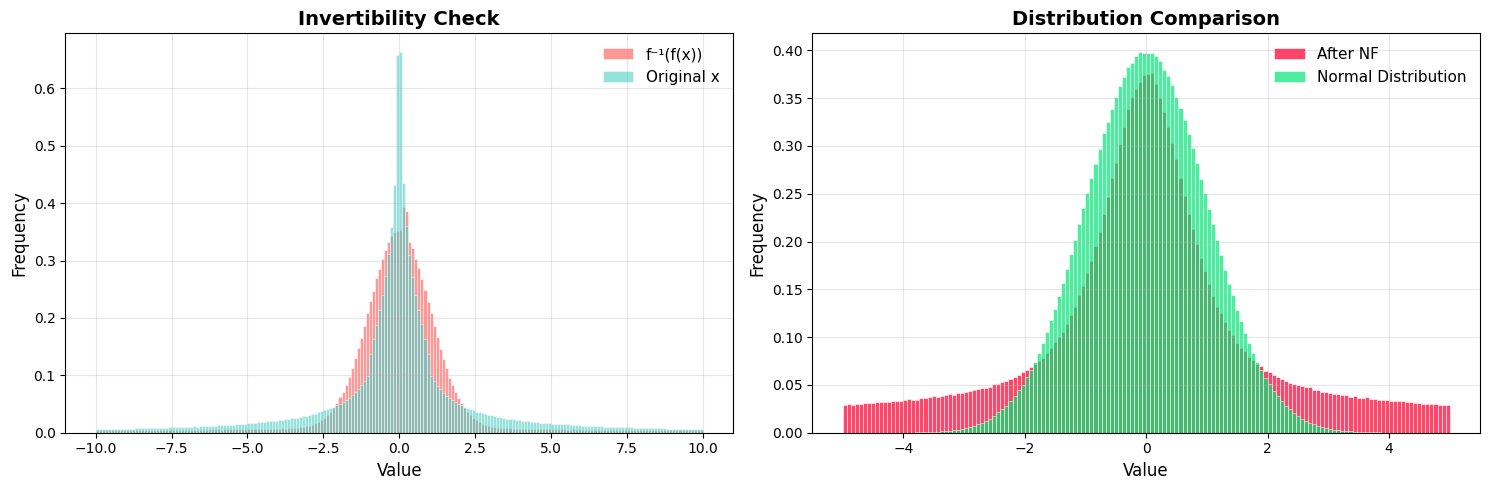

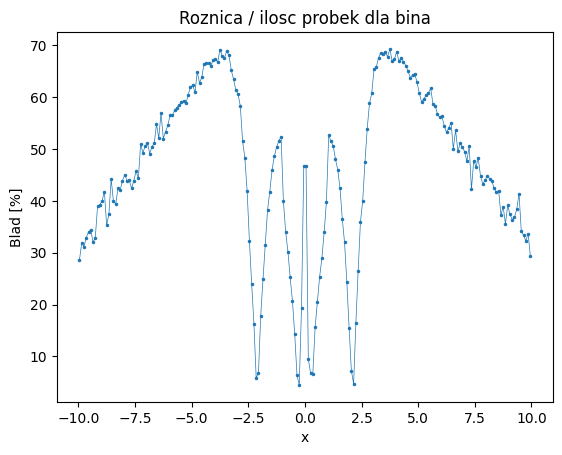

In [18]:
# %%writefile nf.py
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import copy
import numpy as np
from walidacja_funkcji import *

sys.path.append('/home/mamusiaarusia/myenv/lib/python3.12/site-packages/torch')

prober = rs_prober_NKG(0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=None, alpha=None, phi=0.0)

def get_2d_data(PROBE_SIZE: int, prober=prober):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = torch.distributions.Uniform(low=0, high=2*torch.pi).sample((PROBE_SIZE // 2,))
    xs = rs * torch.cos(theta)
    ys = rs * torch.sin(theta)
    return torch.vstack([xs, ys]).T


def get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim = np.array([0,1]), zero_angles = False, eps = 1.0):
    theta_added = np.random.normal(loc=0.0, scale=eps)
    alpha_added = np.random.normal(loc=0.0, scale=eps)
    theta = 0.0 if zero_angles else np.random.uniform(low=0.0, high=np.radians(12)) + theta_added 
    alpha = 0.0 if zero_angles else np.random.uniform(low=0.0, high=np.radians(60)) + alpha_added
    angle_prober = rs_prober_NKG(0.1, looking_x_left=-1, looking_x_right=10, from_x=0, theta=theta, alpha=alpha, phi=0.0)
    x = torch.Tensor(
        get_2d_data(PROBE_SIZE, angle_prober).view(BATCH_SIZE, -1, 2)[:, :, dim]
    )
    angles = torch.Tensor([alpha, theta]).unsqueeze(0).to('cuda')
    x = torch.cat(
        [x, torch.randn([shape for shape in x.shape[:-1]] + [angles.shape[1]]) * 0.01], # zero-paddling with added normal distribution
        dim=1 # zaleznie w sumie 
    ).to('cuda')
    return x, angles


class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module]):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.to('cuda')

    def forward(self, input: torch.Tensor): # wplyw od katow jest raczej dosc niewielki
        h = input.shape[-1] // 2
        x1, x2 = input[:, :h], input[:, h:]
        s = self.scale(x1)
        t = self.translate(x1)
        x2 = x2 * torch.exp(s) + t
        z = torch.cat([x2, x1], dim=-1)
        log_diag = s.sum(dim=-1).mean()
        
        return z, log_diag

    def inverse(self, input: torch.Tensor): 
        h = input.shape[-1] // 2
        x1, x2 = input[:, h:], input[:, :h]
        s = self.scale(x1)
        t = self.translate(x1)
        x2 = (x2 - t) * torch.exp(-s)
        z = torch.cat([x2, x1], dim=-1)
        return z, -s

class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float):
        super().__init__()

        scaling_components = [ 
            nn.Linear(input_size, input_size), nn.Tanh(),
            nn.Linear(input_size, input_size),
        ]

        translating_components = [
            nn.Linear(input_size, input_size), # +2 bo katy
        ]

        self.layers = nn.ModuleList(
            [NF_layer(copy.deepcopy(translating_components), copy.deepcopy(scaling_components)) 
            for _ in range(num_layers)]
        )
        self.optim = torch.optim.Adam(self.parameters(), lr)
        self.to('cuda')

    def forward(self, x):
        return self.iterate_layers(x, forward=True, learn=False)

    def inverse(self, x):
        return self.iterate_layers(x, forward=False, learn=False)

    def loss_and_step(self, x, angles, eps):
        return self.iterate_layers(x, forward=True, learn=True, angles=angles, eps=eps)

    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool, angles=None, eps=1):
        output = input
        diag_sum = torch.zeros((1,)).to('cuda')
        
        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            if forward:
                output, diag_temp = layer.forward(output)
            else:
                output, diag_temp = layer.inverse(output)
            
            if learn:
                diag_sum += diag_temp

        if learn:
            self.optim.zero_grad()
            loss = 0.5 * output[:, :-angles.shape[1]].pow(2).sum(dim=-1).mean() \
                - diag_sum \
                + torch.pow(output[:, -angles.shape[1]:] - angles, 2).sum(dim=-1).mean() / (2 * eps ** 2)
            
            loss.backward()
            self.optim.step()

            return loss

        return output


def learn_nf(nf_model: nn.Module, SAMPLES_TO_RETURN: int, BATCH_SIZE: int, EPOCHS: int, dim: int = 0, eps: float = 1e-5):
    PROBE_SIZE = SAMPLES_TO_RETURN * BATCH_SIZE
    x, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim, eps=eps)
    loss_history = np.empty(EPOCHS)

    nf_model.train()
    for epoch in range(EPOCHS):
        loss_history[epoch] = nf_model.loss_and_step(x, angles, eps)
        print(f'\r{epoch / (EPOCHS - 1) * 100:.1f}%', end='', flush=True)
        x, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim, eps=eps)

    nf_model.eval()
    
    plt.plot(loss_history, 'o', markersize=.3)
    plt.ylim([np.min(loss_history[400:]), np.sort(loss_history[400:])[-15]])
    plt.title(r'$log_{10}$(Loss)')
    plt.show()

    x, angles = get_shower_data_with_angle(PROBE_SIZE * 10, BATCH_SIZE * 10, dim, eps=eps)
    theory = np.random.randn(PROBE_SIZE * 10)
    to_inverse = torch.Tensor(theory).reshape(BATCH_SIZE * 10, SAMPLES_TO_RETURN // 2, 2).to('cuda')[:, :, dim]
    to_inverse = torch.cat([to_inverse, angles.expand(size=(to_inverse.shape[0], 2))], dim=1)

    values = nf_model.forward(x)
    inversed = nf_model.inverse(to_inverse).detach().flatten().cpu().numpy()
    values = values.detach().flatten().cpu().numpy()

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['#FF6B6B', '#4ECDC4']
    
    inversed_bins, edges, _ = ax1.hist(inversed, bins=200, range=[-10, 10], label='f⁻¹(f(x))', 
            color=colors[0], alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
    theory_bins, _, _ = ax1.hist(x.detach().flatten().cpu().numpy(), bins=200, range=[-10, 10], label='Original x', 
            color=colors[1], alpha=0.6, edgecolor='white', linewidth=0.5, density=True)
    ax1.set_title('Invertibility Check', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Value', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(frameon=False, fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(values, bins=150, range=[-5, 5], label='After NF',
            color='#FF1744', alpha=0.8, edgecolor='white', linewidth=0.5, density=True)
    ax2.hist(theory, bins=150, range=[-5, 5], label='Normal Distribution',
            color='#00E676', alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
    ax2.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Value', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend(frameon=False, fontsize=11)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    avg_edges = (edges[1:] + edges[:-1]) / 2
    plt.title('Roznica / ilosc probek dla bina')
    plt.plot(avg_edges, np.clip(np.abs(inversed_bins - theory_bins) / (np.maximum(inversed_bins, theory_bins)) * 100, 0, 100), '-o', markersize=1.5, linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('Blad [%]')
    plt.show()

    return loss_history


SAMPLES_TO_RETURN = 768
DIMS = SAMPLES_TO_RETURN // 4 + 1
BATCH_SIZE = 1024
EPOCHS = 20_000
LR = 1.5e-4
EPSILON = np.radians(1) # std dev added to the angle

x_model = NF(6, DIMS, LR)
x_loss = learn_nf(x_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 0, EPSILON)

y_model = NF(10, DIMS, LR)
y_loss = learn_nf(y_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 1, EPSILON)

[ 1.4913682 -1.8686671]


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_15088/3506269474.py:20: SyntaxWarning: invalid escape sequence '\d'
  fig.suptitle(rf'Dla katow {"$\degree$, ".join(np.degrees(angles.detach().cpu().flatten().numpy()).round(1).astype(str))}$\degree$')
/home/mamusiaarusia/praktyki/walidacja_funkcji.py:122: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],


Text(0, 0.5, 'y')

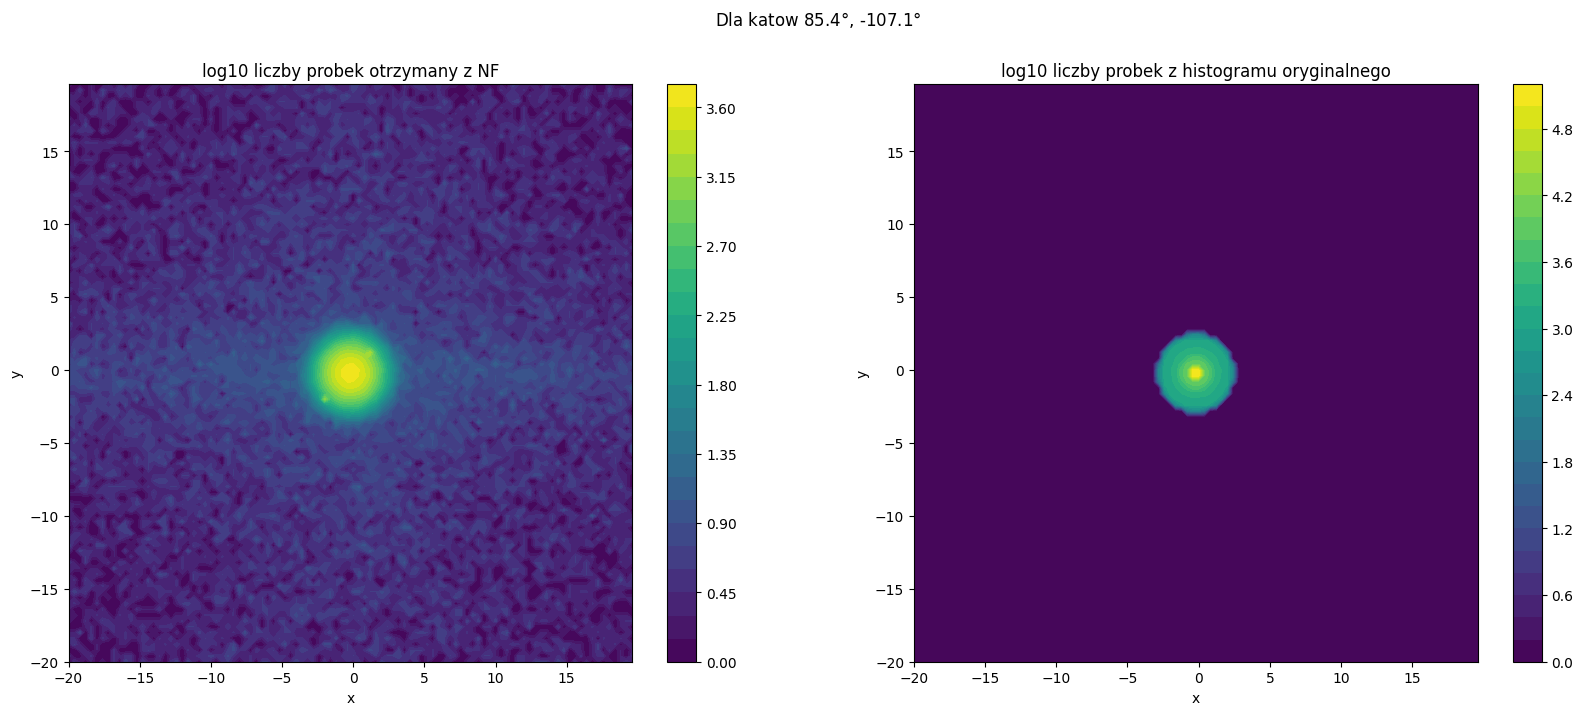

In [52]:
PROBE_SIZE = SAMPLES_TO_RETURN * BATCH_SIZE
normal_dist = torch.randn(size=(BATCH_SIZE, SAMPLES_TO_RETURN // 2, 2)).to('cuda')
theory, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE)

x_normal_dist, y_normal_dist = normal_dist[:, :, 0], normal_dist[:, :, 1]
x_normal_dist = torch.cat([x_normal_dist, angles.expand(BATCH_SIZE, 2)], dim=1)
y_normal_dist = torch.cat([y_normal_dist, angles.expand(BATCH_SIZE, 2)], dim=1)

x_nkg = x_model.inverse(x_normal_dist).detach().cpu().numpy().reshape(-1)
y_nkg = y_model.inverse(y_normal_dist).detach().cpu().numpy().reshape(-1)

x_theory, y_theory = theory[:, :, 0].flatten().cpu().numpy(), theory[:, :, 1].flatten().cpu().numpy()
original_hist, x_edges_orig, y_edges_orig = np.histogram2d(x_theory, y_theory, bins=100, range=[[-20, 20], [-20, 20]])

hist, x_edges, y_edges = np.histogram2d(x_nkg, y_nkg, bins=100, range=[[x_edges_orig[0], x_edges_orig[-1]], [y_edges_orig[0], y_edges_orig[-1]]])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5))

print(f'{angles.detach().cpu().flatten().numpy()}')

fig.suptitle(rf'Dla katow {"$\degree$, ".join(np.degrees(angles.detach().cpu().flatten().numpy()).round(1).astype(str))}$\degree$')
ax1.set_title('log10 liczby probek otrzymany z NF')
contour1 = ax1.contourf(x_edges[:-1], y_edges[:-1], np.log10(hist.T + 1), levels=25)
plt.colorbar(contour1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('log10 liczby probek z histogramu oryginalnego')
contour2 = ax2.contourf(x_edges_orig[:-1], y_edges_orig[:-1], np.log10(original_hist.T + 1), levels=25)
plt.colorbar(contour2, ax=ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

[0.22724018 0.0898301 ]


Text(0, 0.5, 'Roznica [stopnie]')

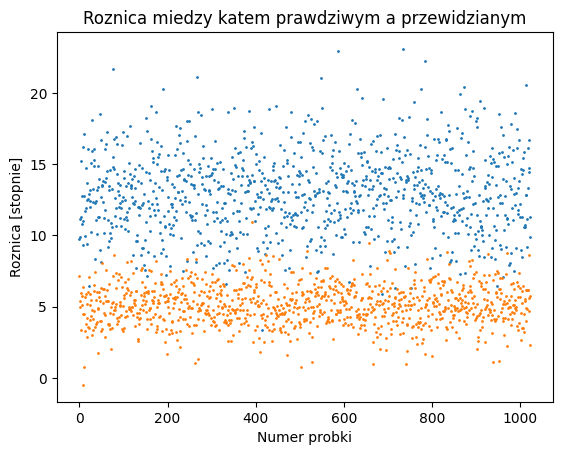

In [62]:
# np.degrees( angles.detach().cpu().numpy() )
# x_model(theory[:, :, 0])
x_theoretical, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, 0, False, EPSILON)
output = x_model(x_theoretical)


angle_diff = torch.abs(output[:, -angles.shape[1]:]) - torch.abs(angles)
print(f'{angle_diff.mean(dim=0).detach().cpu().numpy()}')
plt.title('Roznica miedzy katem prawdziwym a przewidzianym')
plt.plot(np.degrees(angle_diff.cpu().detach().numpy()), 'o', markersize=1)
plt.xlabel('Numer probki')
plt.ylabel('Roznica [stopnie]')

In [54]:
np.degrees(torch.abs(output[:, -angles.shape[1]:]).detach().cpu().numpy())

array([[28.477642 ,  6.965274 ],
       [28.770544 ,  6.7564325],
       [30.887821 ,  7.8263965],
       ...,
       [27.36467  ,  7.03831  ],
       [25.113379 ,  5.966374 ],
       [34.03748  ,  7.6765976]], dtype=float32)

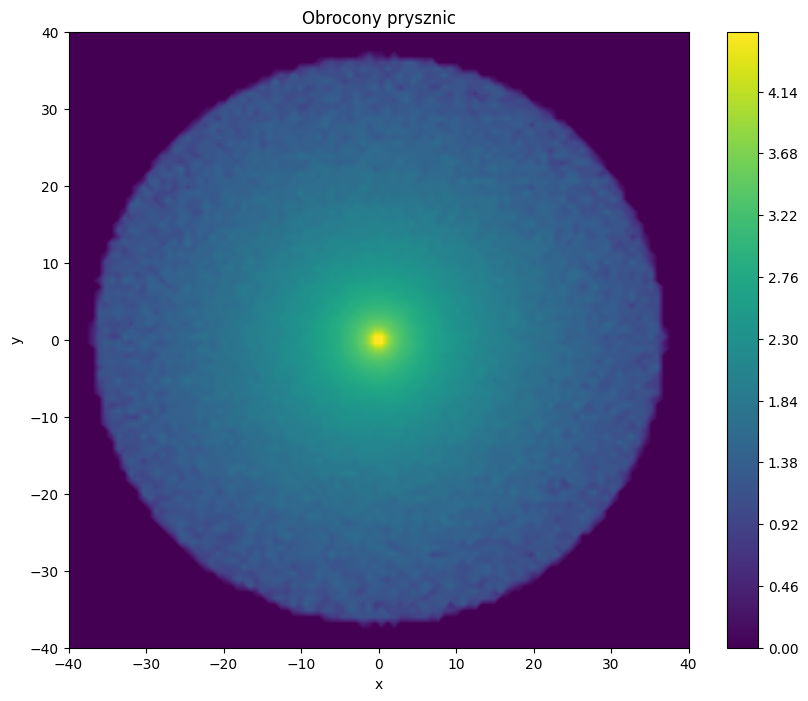

In [55]:
prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=np.radians(30), alpha=np.radians(45), phi=0.0)
ret = get_2d_data(PROBE_SIZE=BATCH_SIZE*SAMPLES_TO_RETURN*2, prober=prober).reshape(-1, 2)
x, y = ret[:, 0], ret[:, 1]
histogram, x_bins, y_bins = np.histogram2d(x, y, bins=100, range=[
    [-40, 40], 
    [-40, 40]
])

plt.figure(figsize=(10, 8))
plt.title('Obrocony prysznic')
plt.contourf( np.log10(histogram + 1), extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], levels=1000 )
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()